<a href="https://colab.research.google.com/github/RodolfoFerro/psychopathology-fer-assistant/blob/master/model/Convolutional_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional model

Since we now have a dataset composed mainly by images, we are going to tackle the emotion classification problem with a convolutional neural network model, which has been proved to be efficient for these kind of problems.

## Model architecture

After some research in the state of the art for Facial Expression Recognition, I found that a simple convolutional architecture based on LeNet-5 would achieve nice results. 

Anyway, more recent proposals have achieved more accurate results, and even if Tensorflow already includes prebuilt models (such as MobileNet, which is one of the best model architectures for portable devices), I came up with my own implementation based on a neetwrk architecture which is supposed to be a deep-lightweight accurate model for the FER problem: "[Extended deep neural network for facial emotion recognition (EDNN)](https://www.sciencedirect.com/science/article/abs/pii/S016786551930008X)" by Deepak Kumar Jaina, Pourya Shamsolmoalib, and Paramjit Sehdev (Elsevier – Pattern Recognition Letters 2019).

In their paper, they assure through some tests that their EDNN gives better results in classification tasks for Facial Expression Recognition, and by the architecture metrics this network turns out to be a more lightweight model compared with others.

In any case, I proceeded to use Tensorflow 2.0 to build my own EDNN implementation with the Keras module.

First of all, we need to upgrade our Tensorflow version:

In [1]:
!pip install -q tensorflow==2.0.0 tensorboard==2.0.0

     |████████████████████████████████| 86.3MB 36kB/s 
     |████████████████████████████████| 3.8MB 51.7MB/s 
     |████████████████████████████████| 450kB 59.6MB/s 


In [2]:
import tensorflow as tf
tf.__version__

'2.0.0'

We can now proceed to build our EDNN model:

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam


def ResidualBlock(prev_layer):
    """Residual block from the EDNN model for FER by Deepak Kumar Jaina,
    Pourya Shamsolmoalib & Paramjit Sehdev, as it appears in "Extended 
    deep neural network for facial emotion recognition", 2019.
    """
    conv_1 = Conv2D(64, (1, 1))(prev_layer)
    conv_2 = Conv2D(64, (3, 3), padding="same")(conv_1)
    shortc = concatenate([conv_1, conv_2], axis=-1)
    conv_3 = Conv2D(128, (3, 3), padding="same")(shortc)
    conv_4 = Conv2D(256, (1, 1))(conv_3)
    output = concatenate([conv_4, prev_layer], axis=-1)
    
    return output


def EDNN(n_classes=7):
    """
    EDNN model for FER by Deepak Kumar Jaina, Pourya Shamsolmoalib &
    Paramjit Sehdev, as it appears in "Extended deep neural network for 
    facial emotion recognition", 2019.
    """

    x = Input(shape=(48, 48, 1))
    y = Conv2D(32, (5, 5), input_shape=(48, 48, 1), strides=(2, 2), 
               data_format='channels_last')(x)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Conv2D(64, (3, 3), strides=(1, 1))(y)
    y = ResidualBlock(y)
    y = Conv2D(128, (3, 3), strides=(1, 1), padding="same")(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Conv2D(128, (3, 3), strides=(1, 1))(y)
    y = ResidualBlock(y)
    y = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Conv2D(512, (3, 3), strides=(1, 1), padding="same")(y)
    y = Flatten()(y)
    y = Dense(1024, activation='relu')(y)
    y = Dropout(0.2)(y)
    y = Dense(512, activation='relu')(y)
    y = Dropout(0.2)(y)
    y = Dense(n_classes, activation='softmax')(y)
    
    # Create model:
    model = Model(x, y)

    # Compile model:
    opt = Adam(lr=LRATE, decay=LRATE/EPOCHS)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

    return model

We now create an instance of our model and verify the details of the architecture:

In [0]:
# Set hyperparameters:
EPOCHS = 10
BATCH = 128
LRATE = 1e-5

# Instance model
ednn = EDNN()

In [5]:
ednn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 22, 22, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 11, 11, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 9, 9, 64)     18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

## Importing the data

We will make use of our "Data exploration" notebook to import some code structure and load our data. You should be able to easily follow what will happen in this section if you access the [corresponding notebook](https://github.com/RodolfoFerro/psychologist-assistant/blob/master/data/Data_exploration.ipynb).

### Getting the data

In [0]:
# Update Kaggle API:
!pip install --upgrade -q kaggle

# Create a new folder for Kaggle config file:
!mkdir /root/.kaggle

In [0]:
import json

token = {
    "username": "rodolfoferro",
    "key": "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
}

with open('/root/.kaggle/kaggle.json', 'w') as config_file:
    json.dump(token, config_file)

In [0]:
# Provide access to Kaggle config file:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 92% 85.0M/92.0M [00:01<00:00, 76.2MB/s]
100% 92.0M/92.0M [00:01<00:00, 90.2MB/s]
 84% 65.0M/77.3M [00:00<00:00, 72.5MB/s]
100% 77.3M/77.3M [00:00<00:00, 92.9MB/s]
 26% 5.00M/19.3M [00:00<00:00, 30.2MB/s]
100% 19.3M/19.3M [00:00<00:00, 76.7MB/s]
 95% 92.0M/96.6M [00:01<00:00, 61.4MB/s]
100% 96.6M/96.6M [00:01<00:00, 94.8MB/s]
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 5.94MB/s]


In [10]:
!tar -xvf "fer2013.tar.gz"

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [0]:
from tensorflow import keras
import pandas as pd
import numpy as np


def load_dataset(net=True):
    """Utility function to load the FER2013 dataset.
    
    It returns the formated tuples (X_train, y_train) , (X_test, y_test).

    Parameters
    ==========
    net : boolean
        This parameter is used to reshape the data from images in 
        (cols, rows, channels) format. In case that it is False, a standard
        format (cols, rows) is used.
    """

    # Load and filter in Training/not Training data:
    df = pd.read_csv('fer2013/fer2013.csv')
    training = df.loc[df['Usage'] == 'Training']
    testing = df.loc[df['Usage'] != 'Training']

    # X_train values:
    X_train = training[['pixels']].values
    X_train = [np.fromstring(e[0], dtype=int, sep=' ') for e in X_train]
    if net:
        X_train = [e.reshape((48, 48, 1)).astype('float32') for e in X_train]
    else:
        X_train = [e.reshape((48, 48)) for e in X_train]
    X_train = np.array(X_train)

    # X_test values:
    X_test = testing[['pixels']].values
    X_test = [np.fromstring(e[0], dtype=int, sep=' ') for e in X_test]
    if net:
        X_test = [e.reshape((48, 48, 1)).astype('float32') for e in X_test]
    else:
        X_test = [e.reshape((48, 48)) for e in X_test]
    X_test = np.array(X_test)

    # y_train values:
    y_train = training[['emotion']].values
    y_train = keras.utils.to_categorical(y_train)

    # y_test values
    y_test = testing[['emotion']].values
    y_test = keras.utils.to_categorical(y_test)

    return (X_train, y_train) , (X_test, y_test)

### Data loading

We can now use our main funciton to load the complete dataset.

In [0]:
(X_train, y_train) , (X_test, y_test) = load_dataset()

And again, to be consistent, we can access the data:

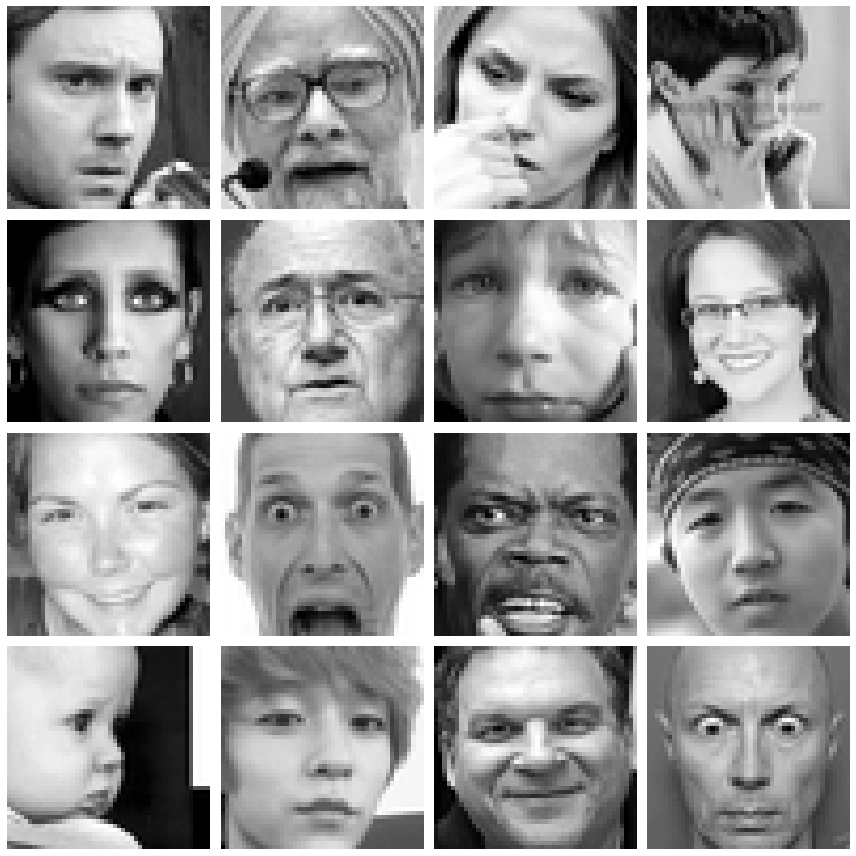

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i].reshape((48, 48)), cmap="gray")
    plt.axis('off')
    plt.tight_layout()

## Model training

So far we have created out model and we already have loaded the datset. We can now proceed to train the model.

In [14]:
# Fit the model:
history = ednn.fit(X_train, y_train,
                   validation_data=(X_test, y_test),
                   epochs=EPOCHS, batch_size=BATCH)

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 418s 15ms/sample - loss: 1.9729 - accuracy: 0.2463 - val_loss: 1.6999 - val_accuracy: 0.3261
Epoch 2/10
28709/28709 [==============================] - 414s 14ms/sample - loss: 1.7223 - accuracy: 0.3222 - val_loss: 1.6399 - val_accuracy: 0.3664
Epoch 3/10
28709/28709 [==============================] - 414s 14ms/sample - loss: 1.6428 - accuracy: 0.3617 - val_loss: 1.5890 - val_accuracy: 0.3884
Epoch 4/10
28709/28709 [==============================] - 410s 14ms/sample - loss: 1.6004 - accuracy: 0.3827 - val_loss: 1.5959 - val_accuracy: 0.3849
Epoch 5/10
28709/28709 [==============================] - 408s 14ms/sample - loss: 1.5613 - accuracy: 0.4012 - val_loss: 1.5397 - val_accuracy: 0.4128
Epoch 6/10
28709/28709 [==============================] - 411s 14ms/sample - loss: 1.5236 - accuracy: 0.4173 - val_loss: 1.5162 - val_accuracy: 0.4175
Epoch 7/10
28709/28709 [=====================

Let's evaluate the model:

In [15]:
# Final evaluation of the model:
scores = ednn.evaluate(X_test, y_test, verbose=False)
print(f'Test accuracy: {scores[1]}')

Test accuracy: 0.4428810179233551


We can also get the plot of the training along the time.

In [0]:
def plot_loss(history):
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model's training loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


def plot_accuracy(history):
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Model's training accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

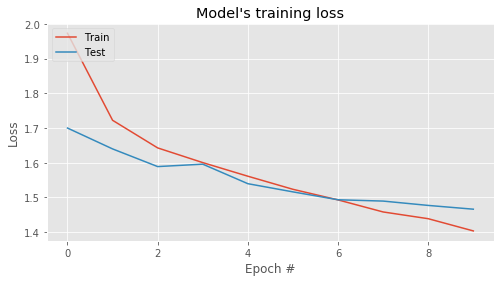

<Figure size 432x288 with 0 Axes>

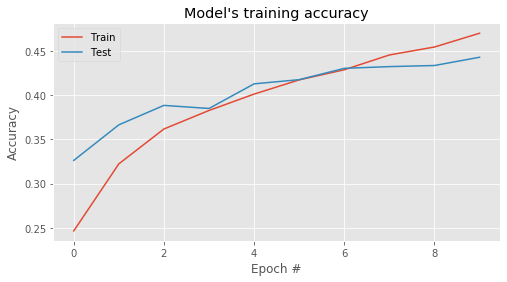

<Figure size 432x288 with 0 Axes>

In [17]:
# Plot loss:
plot_loss(history)
plt.savefig('loss.png', dpi=300)

# Plot accuracy:
plot_accuracy(history)
plt.savefig('accuracy.png', dpi=300)

Another way to validate accuracy is using a confusion matrix:

In [0]:
# Create emotions map:
emotion_labels = [
    'Angry',
    'Disgust',
    'Fear',
    'Happy',
    'Sad',
    'Surprise',
    'Neutral'
]

# Predict using trained model:
y_pred = ednn.predict(X_test)
y_pred = np.asarray([np.argmax(e) for e in y_pred])
y_true = np.asarray([np.argmax(e) for e in y_test])

[Text(58.5, 0.5, 'True label'), Text(0.5, 58.5, 'Predicted label')]

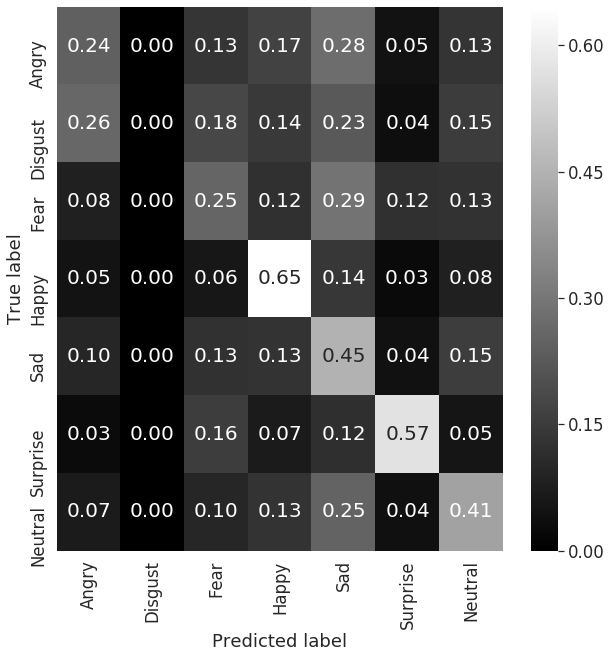

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Compute confusion matrix:
cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix:
sns.set(font_scale=1.5) 
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                 cmap='gray', yticklabels=emotion_labels,
                 xticklabels=emotion_labels, vmin=0,
                 vmax=np.max(cm_normalised), fmt=".2f",
                 annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

### Saving the trained model

To save the trained model we will basically do two things:

- Serialize the model into a JSON file, which will save the architecture of our model.
- Serialize the weights into a HDF5 file, which will save all parameters of our model.

In [20]:
# Serialize model to JSON:
json_ednn = ednn.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(json_ednn)

# Serialize weights to HDF5 (h5py needed):
ednn.save_weights('model.h5')
print('Model saved to disk.')

Model saved to disk.


Since we care about serving the model on a Raspberry Pi, we convert the model using TensorFlow Lite.

In [24]:
# Save the model usinf tf.keras:
ednn.save('tf_model')

# Convert the model to tf.lite and apply quantization:
converter = tf.lite.TFLiteConverter.from_saved_model('tf_model')
# tflite_model = converter.convert()
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open('tf_model.tflite', 'wb').write(tflite_quant_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: tf_model/assets


4124904

### Downloading the saved model

We just need to import the Google Colab module and download the specified files.

In [0]:
from google.colab import files

model_files = ['model.json', 'model.h5', 'tf_model.tflite']
for file in model_files:
    files.download(file)